In [38]:
from datasets import load_dataset, Audio
import pandas as pd
import warnings
import random
import requests
import gzip
from collections import Counter
import numpy as np
import io
import numpy.core.multiarray as multi
from sklearn.metrics import classification_report, balanced_accuracy_score
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split
import soundfile as sf
import gzip
import torch
import matplotlib.pyplot as plt
from IPython.display import Audio as iAudio
from npc_gzip.compressors.base import BaseCompressor
from npc_gzip.compressors.bz2_compressor import Bz2Compressor
from npc_gzip.compressors.gzip_compressor import GZipCompressor
from npc_gzip.knn_classifier import KnnClassifier

In [47]:
compressor = GZipCompressor()

In [39]:
def get_data(dataset) -> tuple:
    """
    Pulls the Project CETI sperm whale vocalizations
    training data and the second being the test
    data. Each tuple contains the audio and label
    respectively as numpy arrays.

    """

    train_iter = dataset['train']
    test_iter = dataset['test']

    train_audio =  [audio_array['bytes'] for audio_array in train_iter['audio']]
    train_labels = train_iter['coda_type']
    
    test_audio  = [audio_array['bytes'] for audio_array in test_iter['audio']]
    test_labels = test_iter['coda_type']
    
    train_audio = np.array(train_audio)
    train_labels = np.array(train_labels)

    test_audio = np.array(test_audio)
    test_labels = np.array(test_labels)

    train = (train_audio, train_labels)
    test = (test_audio, test_labels)

    return (train, test)

In [41]:
def fit_model(comp: BaseCompressor, train_audio: np.ndarray, train_labels: np.ndarray, distance_metric: str = "ncd") -> KnnClassifier:
    """
    Fits a Knn-GZip compressor on the train
    data and returns it.

    Arguments:
        train_text (np.ndarray): Training dataset as a numpy array.
        train_labels (np.ndarray): Training labels as a numpy array.

    Returns:
        KnnClassifier: Trained Knn-Compressor model ready to make predictions.
    """
    compressor: BaseCompressor = comp
    model: KnnClassifier = KnnClassifier(
        compressor=compressor,
        training_inputs=train_audio,
        training_labels=train_labels,
        distance_metric=distance_metric,
    )

    return model

In [42]:
dataset = load_dataset("autumnjohnson/ceti_audio").cast_column("audio", Audio(decode=False, sampling_rate=16000))

In [43]:
((train_audio, train_labels), (test_audio, test_labels)) = get_data(dataset)

## Train model

In [45]:
model = fit_model(compressor, train_audio, train_labels)

## Initialize test data

In [48]:
random_indicies = np.random.choice(test_audio.shape[0], len(test_audio), replace=False)

In [49]:
sample_test_text = test_audio[random_indicies]

In [51]:
sample_test_labels = test_labels[random_indicies]

## Generate predictions for test set

In [52]:
 # Here we use the `sampling_percentage` to save time
 # at the expense of worse predictions. This
 # `sampling_percentage` selects a random % of training
 # data to compare `sample_test_text` against rather
 # than comparing it against the entire training dataset.
top_k = 1
(distances, labels, similar_samples) = model.predict(sample_test_text, top_k, sampling_percentage=0.01)

Compressing input...: 100%|██████████| 353/353 [14:16<00:00,  2.43s/it]


In [53]:
flattened_labels = labels.flatten()

In [54]:
p = Counter(flattened_labels)  
l = Counter(sample_test_labels)
x =(l['1+1+3']+p['1+1+3'])
l

Counter({'4R2': 28,
         '1+1+3': 214,
         '9i': 7,
         '8R': 1,
         '5R1': 62,
         '5R2': 13,
         '3D': 2,
         '8D': 5,
         '5R3': 4,
         '2+3': 1,
         '7D1': 2,
         '10R': 2,
         '7i': 3,
         '7D2': 3,
         '4R1': 1,
         '6i': 2,
         '8i': 3})

In [55]:
print(classification_report(sample_test_labels, flattened_labels.reshape(-1)))

              precision    recall  f1-score   support

       1+1+3       0.77      0.94      0.85       214
         10R       0.00      0.00      0.00         2
         2+3       0.00      0.00      0.00         1
          3D       0.00      0.00      0.00         2
         4R1       0.00      0.00      0.00         1
         4R2       0.29      0.07      0.11        28
         5R1       0.84      0.44      0.57        62
         5R2       0.38      0.38      0.38        13
         5R3       0.00      0.00      0.00         4
          6i       0.00      0.00      0.00         2
         7D1       0.00      0.00      0.00         2
         7D2       0.00      0.00      0.00         3
          7i       0.07      0.33      0.11         3
          8D       0.00      0.00      0.00         5
          8R       0.00      0.00      0.00         1
          8i       0.00      0.00      0.00         3
          9i       0.00      0.00      0.00         7

    accuracy              

/home/autumn/.var/app/org.jupyter.JupyterLab/config/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/autumn/.var/app/org.jupyter.JupyterLab/config/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/autumn/.var/app/org.jupyter.JupyterLab/config/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

Confusion matrix:
[[202   0   1   0   0   4   0   2   0   1   0   2   2   0   0   0   0]
 [  2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0]
 [ 24   0   0   1   0   2   0   0   0   0   0   0   1   0   0   0   0]
 [ 13   0   4   7   0   0  27   5   0   0   0   0   6   0   0   0   0]
 [  2   0   3   0   0   0   2   5   0   0   0   0   1   0   0   0   0]
 [  4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0]
 [  2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   1   1   0   0   0   0   1   0   0   0   0]
 [  3   0   0   0   0   1   0   0   0   0   0   1   0   0  

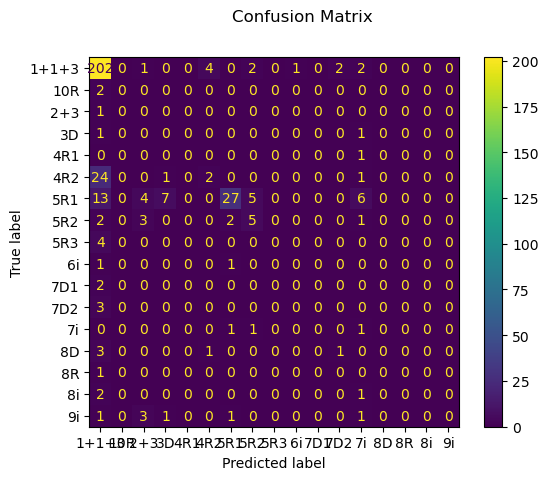

In [56]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(sample_test_labels, flattened_labels.reshape(-1))
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

In [57]:
balanced_accuracy_score(sample_test_labels, flattened_labels.reshape(-1))

0.12757567023469948